In [1]:
import os
for c in os.listdir("data/flower_photos"):
    print(c, len(os.listdir(f"data/flower_photos/{c}")))

daisy 633
dandelion 898
roses 641
sunflowers 699
tulips 799


In [2]:
import time
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

data_dir = "data/flower_photos"
image_size = 128
batch_size = 32

default_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Default device:", default_device)

Default device: cuda


Incarcam dataset-ul de flori, aplicam augmentari pentru train, normalizeazam imaginile, imparte in train/validation si cream DataLoaderele

In [3]:
from torch.utils.data import Subset

def get_dataloaders():
   # for the experiments between 0-10 todo var 1 !!!
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # train_transform = transforms.Compose([
    #     transforms.RandomResizedCrop(size=image_size, scale=(0.8, 1.0)),
    #     transforms.RandomHorizontalFlip(p=0.5),
    #     transforms.RandomRotation(20),
    #     transforms.ColorJitter(
    #         brightness=0.2,
    #         contrast=0.2,
    #         saturation=0.2,
    #         hue=0.1
    #     ),
    #     transforms.ToTensor(),
    #     transforms.Normalize(
    #         mean=[0.485, 0.456, 0.406],
    #         std=[0.229, 0.224, 0.225]
    #     ),
    # ])

    # val_transform = transforms.Compose([
    #     transforms.Resize((image_size, image_size)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(
    #         mean=[0.485, 0.456, 0.406],
    #         std=[0.229, 0.224, 0.225]
    #     ),
    # ])

    # dataset de baza, fara transform (doar pentru split de indecsi)
    base_dataset = datasets.ImageFolder(root=data_dir)
    class_names = base_dataset.classes
    num_classes = len(class_names)

    print("Classes:", class_names)
    print("Number of images:", len(base_dataset))

    train_ratio = 0.8
    train_size = int(train_ratio * len(base_dataset))
    val_size = len(base_dataset) - train_size

    train_subset_base, val_subset_base = random_split(
        base_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    train_indices = train_subset_base.indices
    val_indices = val_subset_base.indices

    full_train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
    full_val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_val_dataset, val_indices)

    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    print("Number of train batches:", len(train_loader))
    print("Number of val batches:", len(val_loader))

    return train_loader, val_loader, class_names, num_classes


# sanity check
train_loader, val_loader, class_names, num_classes = get_dataloaders()


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of images: 3670
Train size: 2936, Val size: 734
Number of train batches: 92
Number of val batches: 23


Returnam functia de activare (ReLU, Tanh, LeakyReLU) pe baza unui string
SI
cream un model CNN configurabil: numar de conv layers, batchnorm, pooling, hidden layers, dimensiuni si activare

In [4]:
def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    if name == "leakyrelu":
        return nn.LeakyReLU(0.1)
    raise ValueError(f"Unknown activation {name}")


class FlexibleCNN(nn.Module):
    """
    Model flexibil:
    - 0–4 convolutional layers
    - (optional) BatchNorm
    - (opt) MaxPooling
    - 1–2 fully connected (hidden) layers
    """

    def __init__(
        self,
        num_classes: int,
        num_conv_layers: int = 3,
        num_hidden_layers: int = 1,
        hidden_dim: int = 256,
        use_batchnorm: bool = True,
        use_pooling: bool = True,
        activation: str = "relu",
    ):
        super().__init__()

        self.num_conv_layers = num_conv_layers
        self.num_hidden_layers = num_hidden_layers
        self.use_batchnorm = use_batchnorm
        self.use_pooling = use_pooling
        self.activation = get_activation(activation)

        layers = []
        in_channels = 3
        out_channels = 32

        if num_conv_layers > 0:
            for i in range(num_conv_layers):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                if use_batchnorm:
                    layers.append(nn.BatchNorm2d(out_channels))
                layers.append(self.activation)
                if use_pooling:
                    layers.append(nn.MaxPool2d(2))

                in_channels = out_channels
                out_channels *= 2

            layers.append(nn.AdaptiveAvgPool2d((4, 4)))
            self.features = nn.Sequential(*layers)

            last_channels = in_channels
            fc_in_dim = last_channels * 4 * 4
        else:
            self.features = nn.Identity()
            fc_in_dim = 3 * image_size * image_size

        self.flatten = nn.Flatten()

        fc_layers = []
        if num_hidden_layers == 1:
            fc_layers.append(nn.Linear(fc_in_dim, hidden_dim))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim, num_classes))
        elif num_hidden_layers == 2:
            fc_layers.append(nn.Linear(fc_in_dim, hidden_dim))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim, hidden_dim // 2))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim // 2, num_classes))
        else:
            raise ValueError("num_hidden_layers must be 1 or 2")

        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
# test
test_model = FlexibleCNN(num_classes=num_classes, num_conv_layers=2, num_hidden_layers=1)
print(test_model)

FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)


Rulam un epoch complet de antrenament, calc loss + accuracy, aplicam L1 daca e activat, face backprop si optimizer.step()

In [5]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, l1_lambda: float = 0.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    start_time = time.time()

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if l1_lambda > 0.0:
            l1_norm = 0.0
            for p in model.parameters():
                l1_norm += p.abs().sum()
            loss = loss + l1_lambda * l1_norm

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    epoch_time = time.time() - start_time
    return epoch_loss, epoch_acc, epoch_time

# Calc loss + accuracy pe validation (fara backprop)
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc

# Return etichetele si predictiile pentru macro-F1 si matricea de confuzie
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds

PLot urile de loss/accuracy si matricea de confuzie

In [6]:
def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_confusion(all_labels, all_preds, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# afis formele parametrilor modelului
def print_model_parameters(model):
    print("\n Model parameters (weights & biases)")
    for name, param in model.named_parameters():
        print(f"{name}: shape={tuple(param.shape)}")

Structura care def un experiment cu hiperparam complet configurabili

In [7]:
@dataclass
class ExperimentConfig:
    name: str
    num_conv_layers: int
    num_hidden_layers: int
    hidden_dim: int
    use_batchnorm: bool
    use_pooling: bool
    activation: str
    learning_rate: float
    l2_lambda: float
    l1_lambda: float
    num_epochs: int
    patience: int = 5

      #todo for 12 ---> pt. fine-tuning mai agresiv
    label_smoothing: float = 0.1
    use_scheduler: bool = False

def get_experiments() -> List[ExperimentConfig]:
    return [
        # 0) MLP – baseline (fără conv, doar fully connected)
        ExperimentConfig(
            name="0",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,   # nu are sens la MLP-ul ăsta simplu aici
            use_pooling=False,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),

        ExperimentConfig(
            name="1",
            num_conv_layers=1,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,   # nu are sens la MLP-ul ăsta simplu aici
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),


        # 2) CNN mediu – 2 conv, fără BN, cu pooling
        ExperimentConfig(
            name="2",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),

        # 3) CNN 2 conv, LR mai mic – efectul lui learning rate
        ExperimentConfig(
            name="3",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=12,
        ),

        # 4) CNN 3 conv + BatchNorm + pooling – modelul foarte bun (fără L1)
        ExperimentConfig(
            name="4",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,
        ),

        # 5) CNN 3 conv + BatchNorm + pooling, dar cu LeakyReLU
        ExperimentConfig(
            name="5",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="leakyrelu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,
        ),

        # 6) CNN mai adânc – 4 conv + BN + pooling, hidden layer mai mare
        ExperimentConfig(
            name="6",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,     # pooling ca să nu explodeze runtime-ul
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=1e-3,       # L2 mai puternic ca să nu suprainvețe
            l1_lambda=0.0,
            num_epochs=15,
        ),

        # 7) CNN fără pooling – cerința "mit / ohne Pooling"
        ExperimentConfig(
            name="7",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=False,    # aici e diferența importantă
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=8,         # poți crește dacă vezi că nu converge
        ),

        # 8) CNN cu L1 activ – cerința "Werte für L1-Regularisierung"
        ExperimentConfig(
            name="8",             # <-- aici era dublura, acum e unic
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=1e-5,       # L1 activ (valoare mică)
            num_epochs=15,
        ),

        # 9) MLP cu tanh – pentru a avea încă o activare diferită
        ExperimentConfig(
            name="9",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,
            use_pooling=False,
            activation="tanh",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),

        # 10) Ultimate CNN – 4 conv + BN + pooling, ReLU, L2 + L1, lr mic
        ExperimentConfig(
            name="10",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=2e-4,
            l2_lambda=7e-4,
            l1_lambda=1e-5,
            num_epochs=25,
        ),
        ExperimentConfig(
            name="11",
            num_conv_layers=4,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.5e-4,
            l2_lambda=6e-4,
            l1_lambda=5e-6,
            num_epochs=30,
        ),
        ExperimentConfig(
            name="12",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.8e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=40,
            patience = 8,
            label_smoothing=0.05,
            use_scheduler=True,
        ),

    ]


experiments = get_experiments()
print(experiments)


[ExperimentConfig(name='0', num_conv_layers=0, num_hidden_layers=2, hidden_dim=512, use_batchnorm=False, use_pooling=False, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.1, use_scheduler=False), ExperimentConfig(name='1', num_conv_layers=1, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.1, use_scheduler=False), ExperimentConfig(name='2', num_conv_layers=2, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.1, use_scheduler=False), ExperimentConfig(name='3', num_conv_layers=2, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.0003, l2_lambda=0.0001, l1_lambda=0.0, num_epo

Ruleaza un experiment complet: construieste modelul, aplica loss cu label smoothing, optimizer Adam, scheduler optional, early stopping, salveaza best model, calculeaza macro-F1 si afiseaza grafice

In [8]:
def run_experiment(
    cfg: ExperimentConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    class_names: List[str],
    num_classes: int,
    device: torch.device,
) -> Dict[str, Any]:
    print("\n" + "=" * 80)
    print(f"Starting experiment: {cfg.name} on device {device}")
    print("=" * 80)

    model = FlexibleCNN(
        num_classes=num_classes,
        num_conv_layers=cfg.num_conv_layers,
        num_hidden_layers=cfg.num_hidden_layers,
        hidden_dim=cfg.hidden_dim,
        use_batchnorm=cfg.use_batchnorm,
        use_pooling=cfg.use_pooling,
        activation=cfg.activation,
    ).to(device)

    print(model)
#todo
  #  criterion = nn.CrossEntropyLoss()
  #  criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)


    optimizer = optim.Adam(
        model.parameters(),
        lr=cfg.learning_rate,
        weight_decay=cfg.l2_lambda,
    )

    #todo for 12
    if cfg.use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
           optimizer,
           T_max=cfg.num_epochs,
        )
    else:
        scheduler = None



    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "epoch_time": [],
    }

    best_val_loss = float("inf")
    best_val_acc = 0.0
    best_state_dict = None
    best_epoch = 0
    no_improve_epochs = 0

    total_start = time.time()

    for epoch in range(1, cfg.num_epochs + 1):
        print(f"\nEpoch {epoch}/{cfg.num_epochs}")
        print("-" * 40)

        train_loss, train_acc, train_time = train_one_epoch(
            model, train_loader, criterion, optimizer, device, l1_lambda=cfg.l1_lambda
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(train_time)

        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
        print(f"Epoch train time: {train_time:.1f} s")

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_state_dict = model.state_dict()
            best_epoch = epoch
            no_improve_epochs = 0
            print(f"new best model (val_loss={best_val_loss:.4f}, val_acc={best_val_acc:.4f})")
        else:
            no_improve_epochs += 1
            print(f"no improvement for {no_improve_epochs} epoch(s)")

                     #todo for 12
        if scheduler is not None:
            scheduler.step()

        if no_improve_epochs >= cfg.patience:
            print(f" early stopping triggered at epoch {epoch}")
            break

    total_time = time.time() - total_start
    print(f"\nTRAINING FINISHED FOR {cfg.name}")
    print(f"Best epoch: {best_epoch} / {cfg.num_epochs}")
    print(f"Best val_loss: {best_val_loss:.4f} | Best val_acc: {best_val_acc:.4f}")
    print(f"Total training time: {total_time:.1f} s")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Final prediction + macro-F1
    all_labels, all_preds = get_predictions(model, val_loader, device)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Macro-F1 on validation: {macro_f1:.4f}")

    print_model_parameters(model)

    plot_history(history, title_prefix=cfg.name)
    plot_confusion(all_labels, all_preds, class_names, title=f"{cfg.name} - Confusion Matrix")

    result = {
        "config": cfg,
        "history": history,
        "macro_f1": macro_f1,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "total_time": total_time,
    }
    return result


def compare_cpu_gpu(cfg: ExperimentConfig, train_loader, val_loader, class_names, num_classes):
    cpu_device = torch.device("cpu")
    gpu_device = torch.device("cuda") if torch.cuda.is_available() else None

    print("\n===== CPU vs GPU comparison for config:", cfg.name, "=====")

    print("\n### Running on CPU ###")
    res_cpu = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, cpu_device)

    if gpu_device is not None:
        print("\n### Running on GPU ###")
        res_gpu = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, gpu_device)

        print("\n=== CPU vs GPU summary ===")
        print(f"CPU total time: {res_cpu['total_time']:.1f} s")
        print(f"GPU total time: {res_gpu['total_time']:.1f} s")
        speedup = res_cpu["total_time"] / res_gpu["total_time"] if res_gpu["total_time"] > 0 else None
        if speedup is not None:
            print(f"Approx. speedup: {speedup:.2f}x")
    else:
        print("No GPU available for comparison.")


  name="0",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,
            use_pooling=False,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,

MLP baseline
Model extrem de simplu, fara convolutii
vrem sa comp cu CNN pentru a arata beneficiul conv layers


Starting experiment: 0 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 5.7531 | Train acc: 0.2776
Val loss: 1.6494 | Val acc: 0.3460
Epoch train time: 21.3 s
new best model (val_loss=1.6494, val_acc=0.3460)

Epoch 2/10
----------------------------------------
Train loss: 1.7516 | Train acc: 0.3052
Val loss: 1.5115 | Val acc: 0.3951
Epoch train time: 17.1 s
new best model (val_loss=1.5115, val_acc=0.3951)

Epoch 3/10
----------------------------------------
Train loss: 1.5829 | Train acc: 0.3256
Val loss: 1.4537 | Val acc: 0.

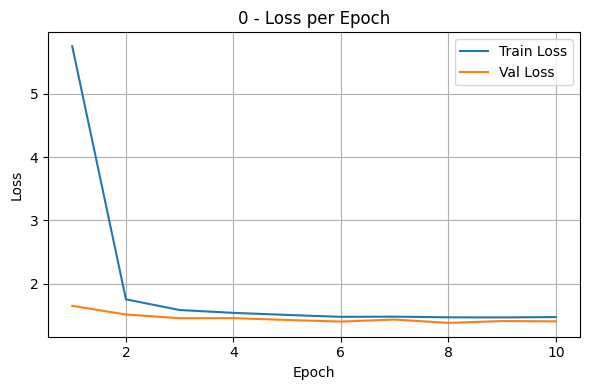

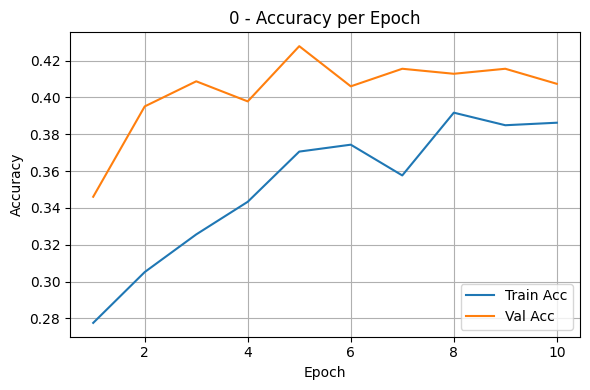

<Figure size 600x600 with 0 Axes>

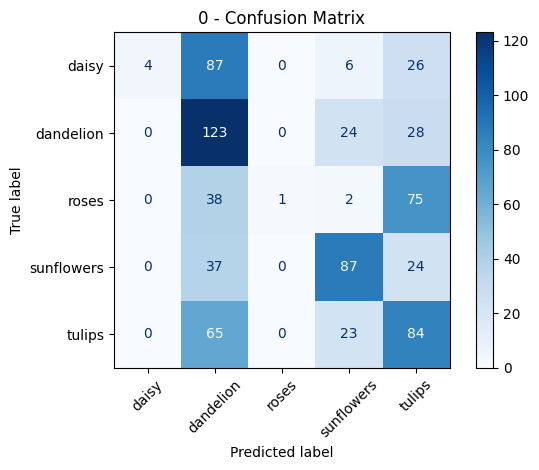

In [9]:
cfg = experiments[0]
result0 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="1",
            num_conv_layers=1,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,

CNN foarte mic (1 convolutie)
Testam impactul unui singur strat conv -
LR 1e-3 pentru convergenta rapida


Starting experiment: 1 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 1.3998 | Train acc: 0.4213
Val loss: 1.2391 | Val acc: 0.5286
Epoch train time: 14.9 s
new best model (val_loss=1.2391, val_acc=0.5286)

Epoch 2/10
----------------------------------------
Train loss: 1.2828 | Train acc: 0.5010
Val loss: 1.2244 | Val acc: 0.5599
Epoch train time: 13.9 s
new best model (val_loss=1.2244, val_acc=0.5599)

Epoch 3/10
---

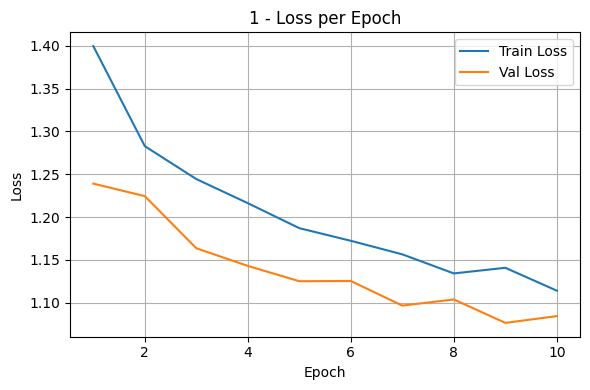

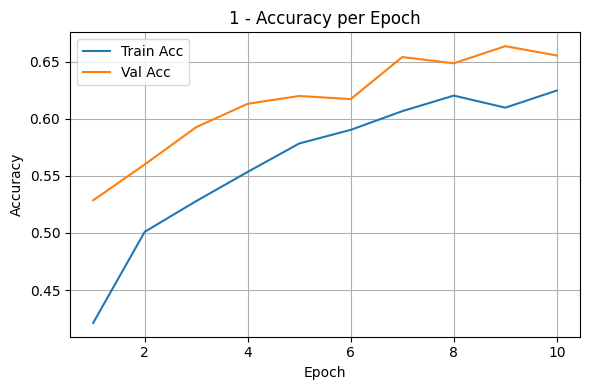

<Figure size 600x600 with 0 Axes>

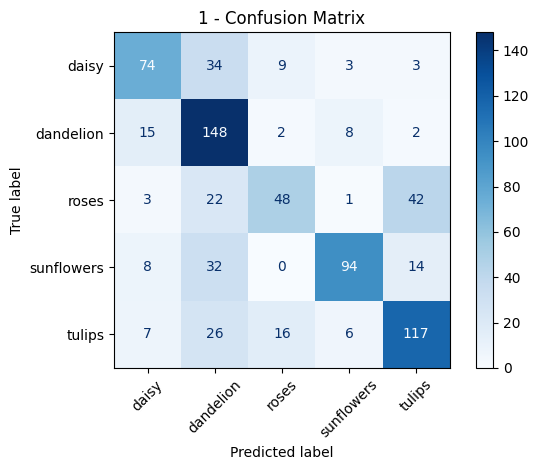

In [10]:
cfg = experiments[1]
result0 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

fname="2",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,

2 conv layers, fara BN
Vedem cum creste performanta doar din cresterea adancimii.



Starting experiment: 2 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 1.3803 | Train acc: 0.4264
Val loss: 1.2149 | Val acc: 0.5354
Epoch train time: 10.5 s
new best model (val_loss=1.2149, val_acc=0.5354)

Epoch 2/10
----------------------------

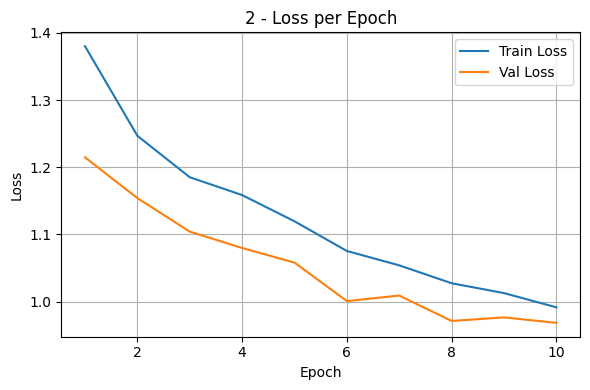

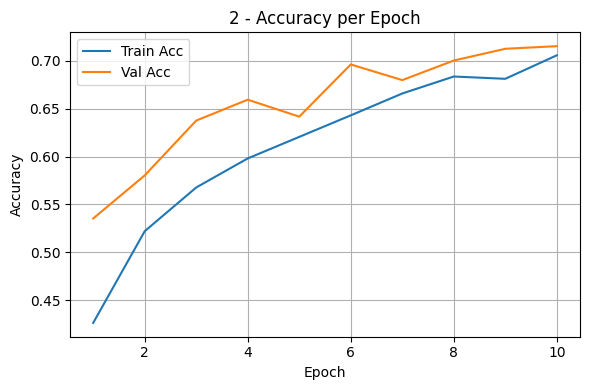

<Figure size 600x600 with 0 Axes>

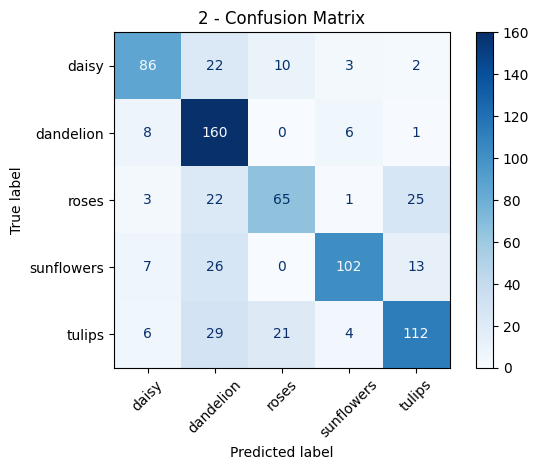

In [11]:
cfg = experiments[2]
result2 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="3",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=12,

2 conv, LR mai mic
Testam efectul unui learning rate redus.



Starting experiment: 3 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/12
----------------------------------------
Train loss: 1.4549 | Train acc: 0.3866
Val loss: 1.2826 | Val acc: 0.4591
Epoch train time: 11.6 s
new best model (val_loss=1.2826, val_acc=0.4591)

Epoch 2/12
----------------------------

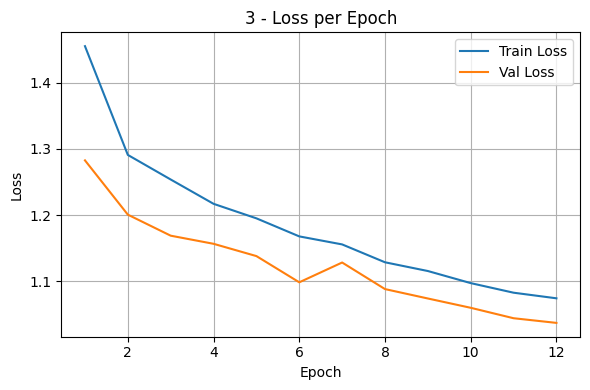

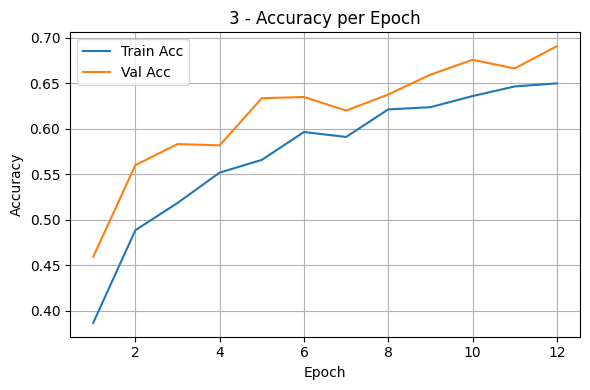

<Figure size 600x600 with 0 Axes>

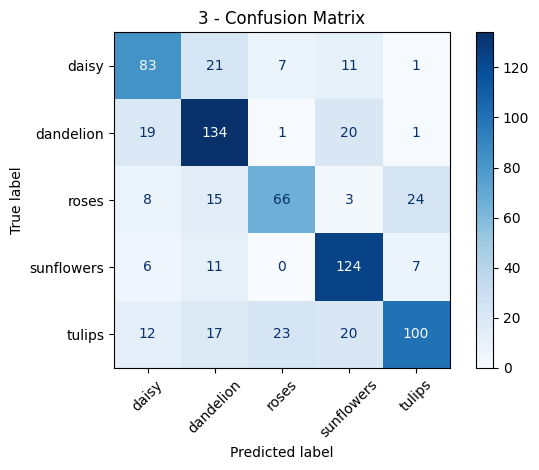

In [12]:
cfg = experiments[3]
result0 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="4",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,

3 conv + BatchNorm
Testam efectul BN asupra stabilitatii si performantei.



Starting experiment: 4 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cla

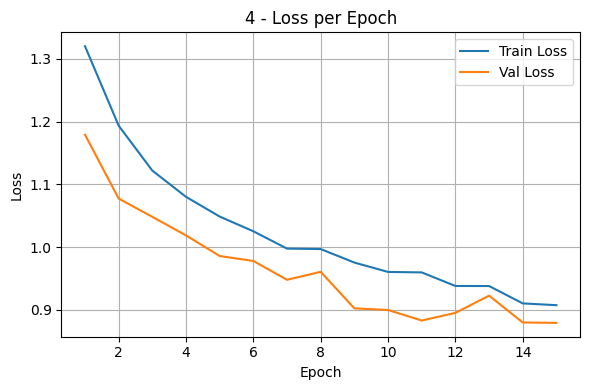

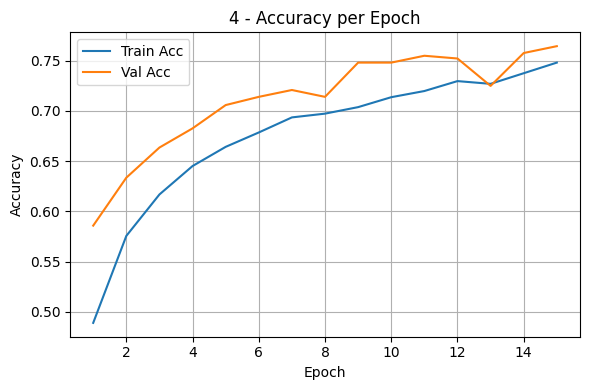

<Figure size 600x600 with 0 Axes>

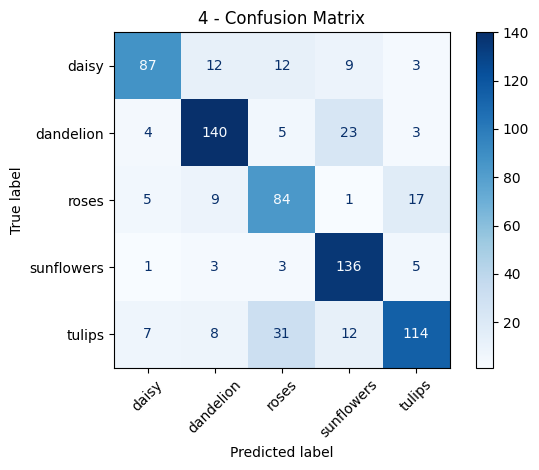

In [13]:
cfg = experiments[4]
result4 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="5",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="leakyrelu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,


3 conv + LeakyReLU
Analizam impactul functiei de activare asupra invatarii.



Starting experiment: 5 on device cuda
FlexibleCNN(
  (activation): LeakyReLU(negative_slope=0.1)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Ad

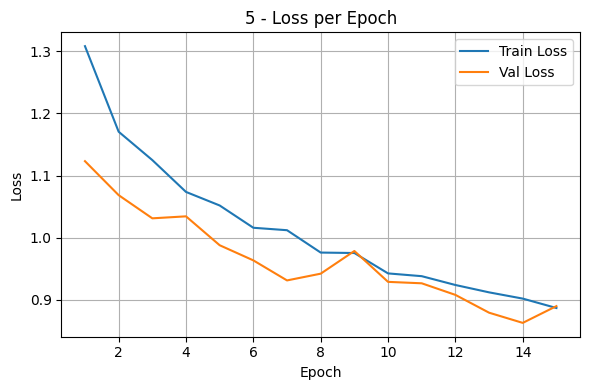

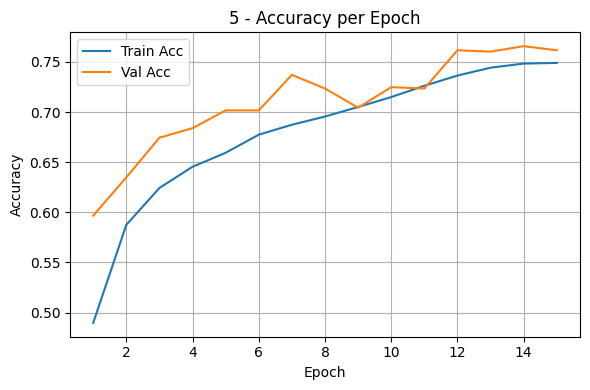

<Figure size 600x600 with 0 Axes>

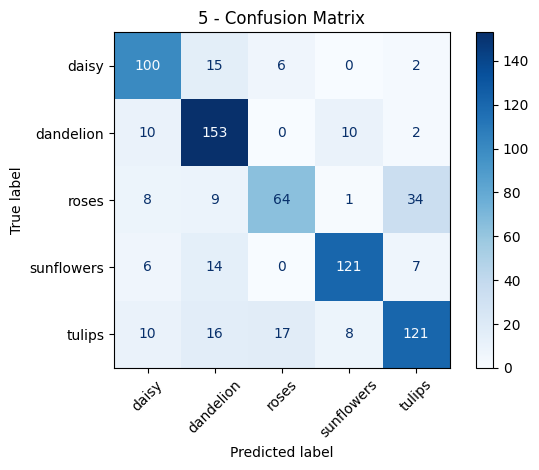

In [14]:
cfg = experiments[5]
result = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

  name="6",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,     # pooling ca să nu explodeze runtime-ul
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=1e-3,       # L2 mai puternic ca să nu suprainvețe
            l1_lambda=0.0,
            num_epochs=15,

4 conv, model mai mare
Capacitate crescuta, necesita L2 mai mare pentru controlul overfitting-ului.



Starting experiment: 6 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256,

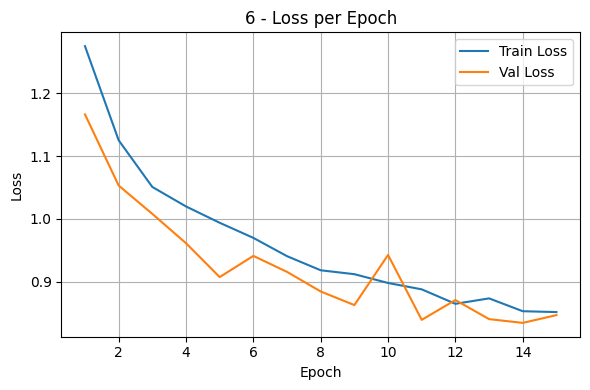

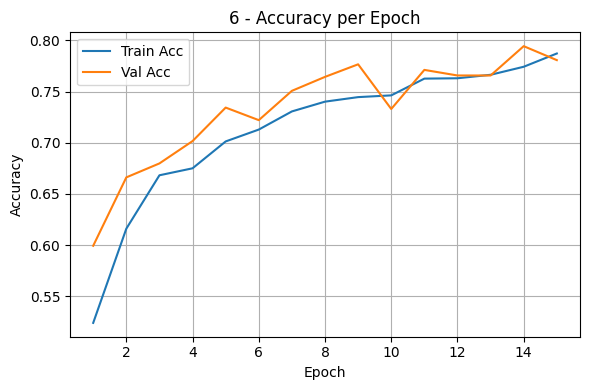

<Figure size 600x600 with 0 Axes>

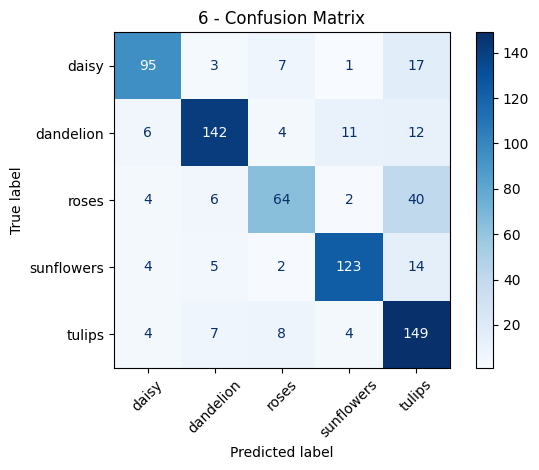

In [15]:
cfg = experiments[6]
result6 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="7",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=False,    # aici e diferenta importanta
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=8,         # poti creste dacă vezi ca nu converge

fara pooling
Testam cerinta “mit / ohne Pooling”.


Starting experiment: 7 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/8
----------------------------------------
Train loss: 1.3709 | Train acc: 0.4268
Val loss: 1.2203 | Val acc: 0.5477
Epoch train time: 11.9 s
new best model (val_loss=1.2203, val_acc=0.5477)

Epoch 2/8
----------------------------------------
Train loss: 1.2533 | Train acc: 0.5313
Val loss: 1.1582 | Val acc: 0.5886
Epoch train time: 12.0 s
new best model (val_loss=1.1582, val_acc=0.5886)

Epoch 3/

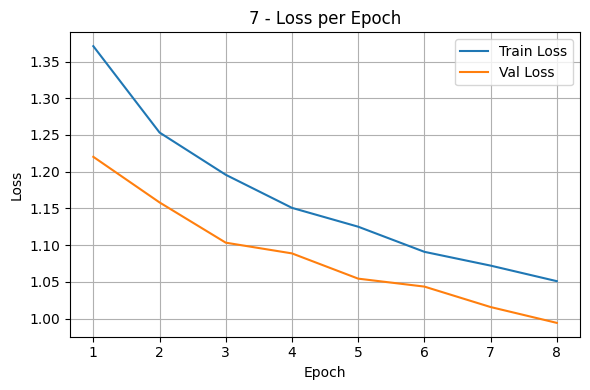

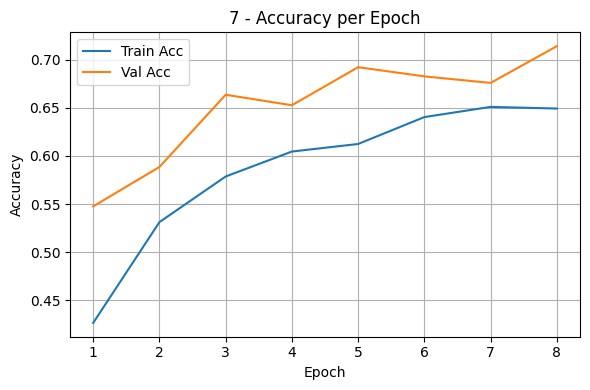

<Figure size 600x600 with 0 Axes>

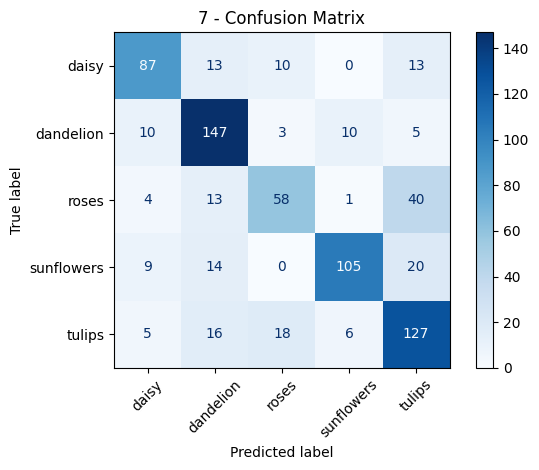

In [16]:
cfg = experiments[7]
result7 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="8",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=1e-5,       # L1 activ (valoare mică)
            num_epochs=15,

L1 regularization
Analizam impactul L1 asupra greutatilor si generalizarii.


Starting experiment: 8 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cla

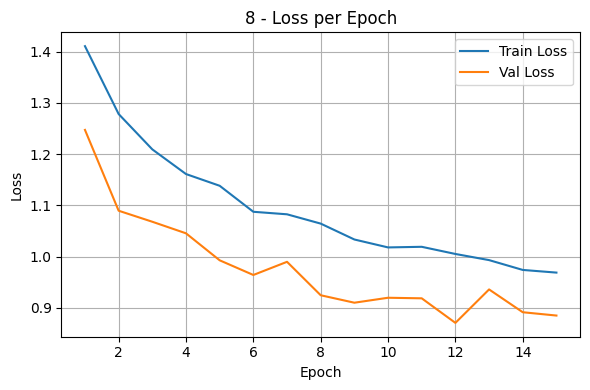

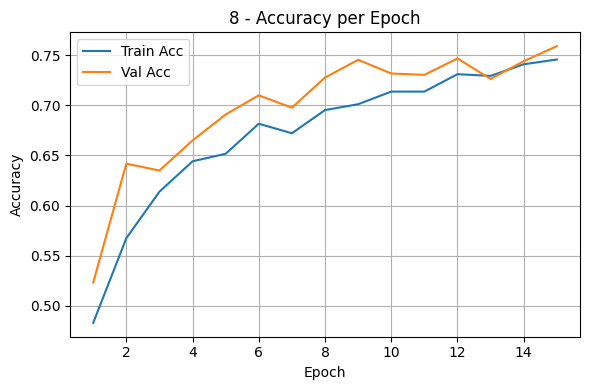

<Figure size 600x600 with 0 Axes>

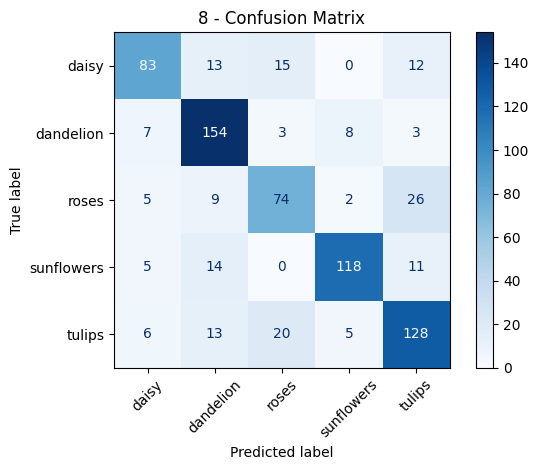

In [17]:
cfg = experiments[8]
result8 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="9",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,
            use_pooling=False,
            activation="tanh",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,

MLP cu Tanh
Comparatie intre activari si impact asupra unui model non-convolutional.


Starting experiment: 9 on device cuda
FlexibleCNN(
  (activation): Tanh()
  (features): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 1.5729 | Train acc: 0.3202
Val loss: 1.4073 | Val acc: 0.3978
Epoch train time: 10.7 s
new best model (val_loss=1.4073, val_acc=0.3978)

Epoch 2/10
----------------------------------------
Train loss: 1.4941 | Train acc: 0.3450
Val loss: 1.4127 | Val acc: 0.3869
Epoch train time: 10.2 s
no improvement for 1 epoch(s)

Epoch 3/10
----------------------------------------
Train loss: 1.4725 | Train acc: 0.3617
Val loss: 1.3692 | Val acc: 0.4319
Epoch train ti

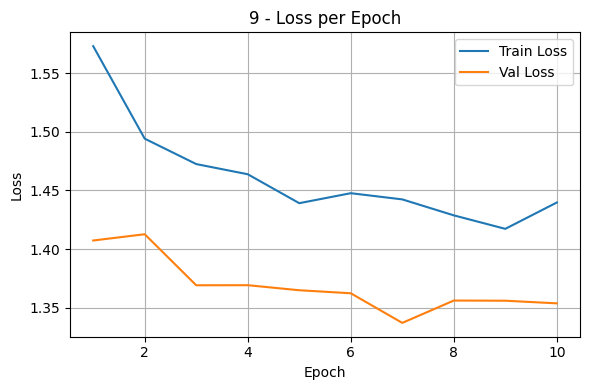

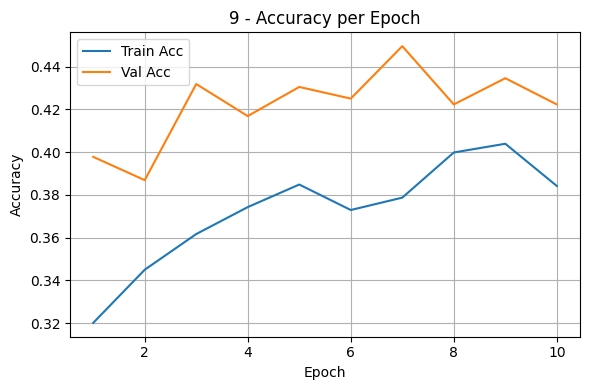

<Figure size 600x600 with 0 Axes>

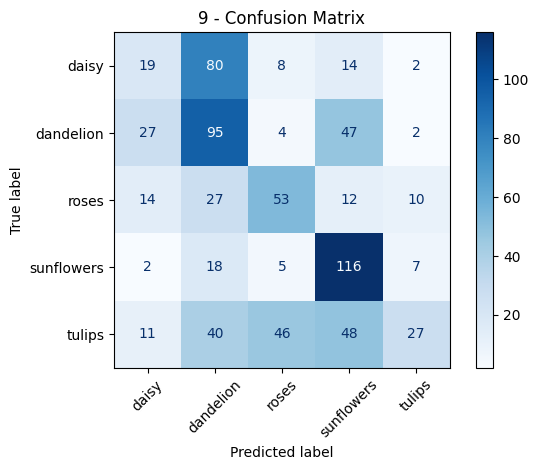

In [18]:
cfg = experiments[9]
result9 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="10",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,
            use_pooling=False,
            activation="tanh",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,

“Ultimate CNN”: 4 conv + BN, L1 + L2, LR mic → testam un setup optimizat.


Starting experiment: 10 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256

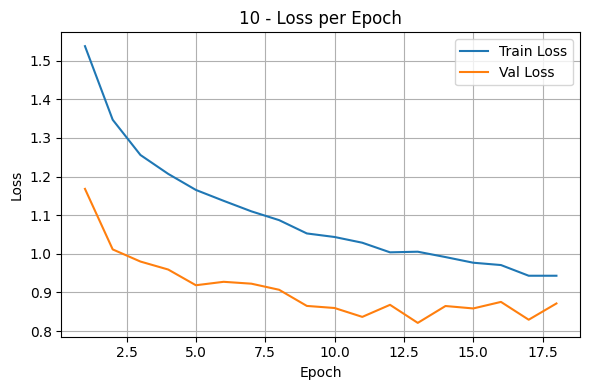

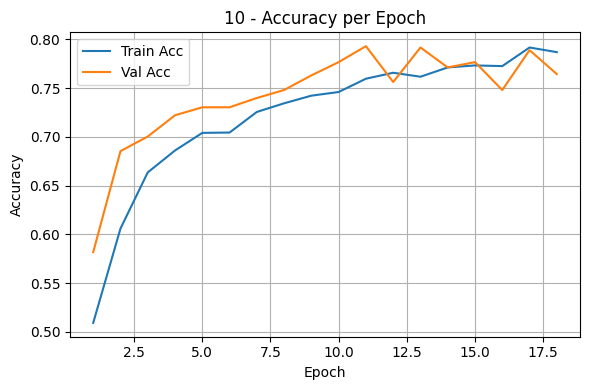

<Figure size 600x600 with 0 Axes>

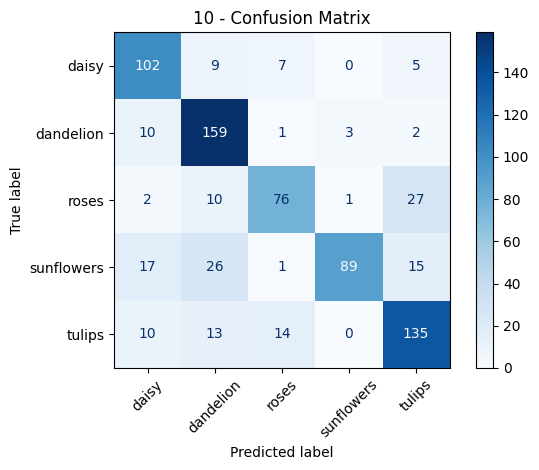

In [19]:
cfg = experiments[10]
result9 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

name="11",
            num_conv_layers=4,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.5e-4,
            l2_lambda=6e-4,
            l1_lambda=5e-6,
            num_epochs=30,

classifier mai adanc
Testam efectul unui numar mai mare de fully connected layers.


Starting experiment: 11 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256

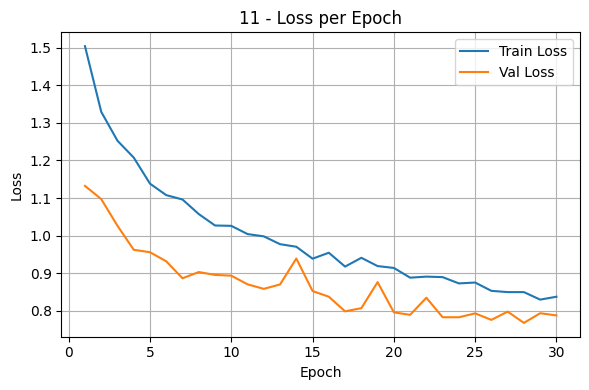

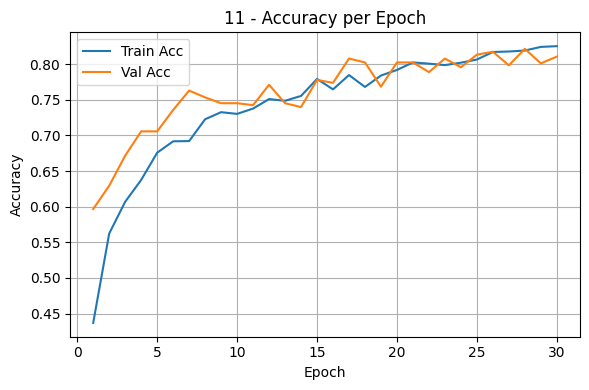

<Figure size 600x600 with 0 Axes>

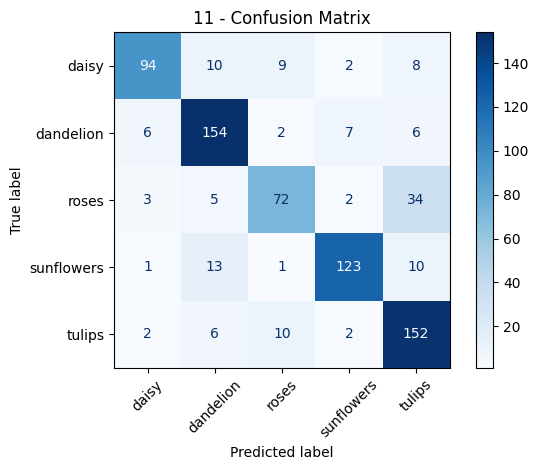

In [20]:
cfg = experiments[11]
result9 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

  name="12",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.8e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=40,
            patience = 8,
            label_smoothing=0.05,
            use_scheduler=True,

model optim cu scheduler,
4 conv, label smoothing, CosineAnnealing, early stopping → maximizeaza macro-F1


Starting experiment: 12 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256

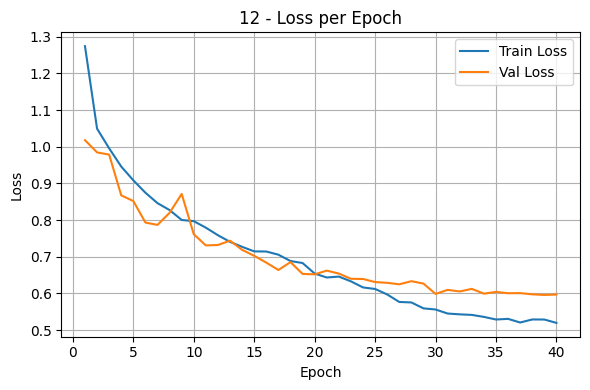

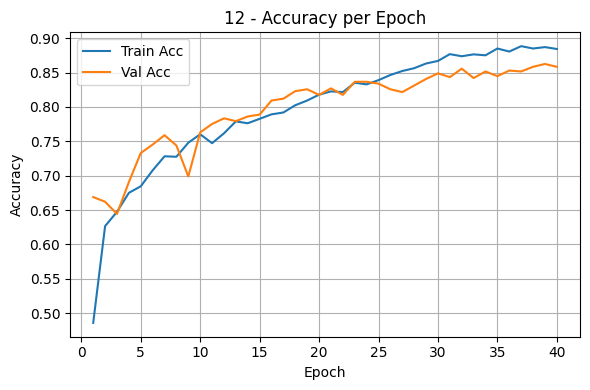

<Figure size 600x600 with 0 Axes>

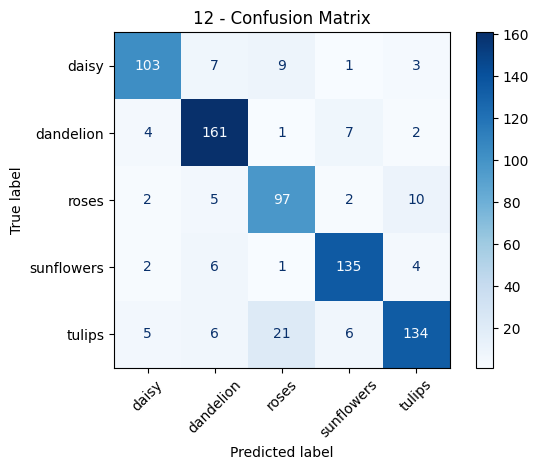

In [21]:
cfg = experiments[12]
result9 = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, device=default_device)

Pe CPU antrenarea este mult mai lenta, deoarece operatiile de convolutie sunt foarte costisitoare si procesorulle executa in mare parte secvential. Un epoch dureaza ~55–65 secunde, iar tot experimentul ~1000 secunde

vs

Pe GPU antrenarea este mult mai rapida (de obicei 5x–20x), pentru ca operatiile pe tensori sunt executate in paralel pe mii de nuclee, ceea ce accelereaza puternic CNN urile

Modelul folosit are 3 straturi convolutionale + BatchNorm + MaxPooling, apoi un classifier cu un singur hidden layer si dropout

Rezultatul pe CPU:
Best val_acc: 0.7725
Macro-F1: 0.7270
Timp total: ~995 s

Concluzie:
CPU este mult mai lent deoarece proceseaza operatiile una cate una, in timp ce GPU le ruleaza masiv in paralel


===== CPU vs GPU comparison for config: 4 =====

### Running on CPU ###

Starting experiment: 4 on device cpu
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(outp

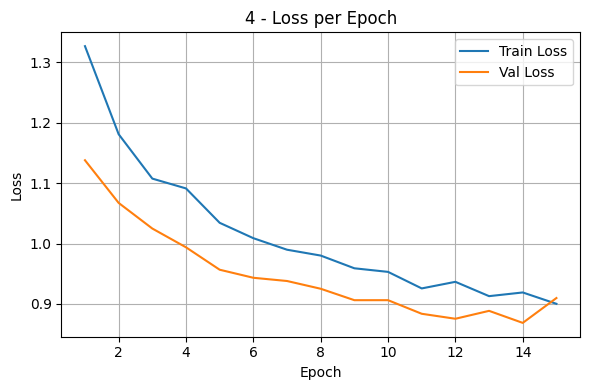

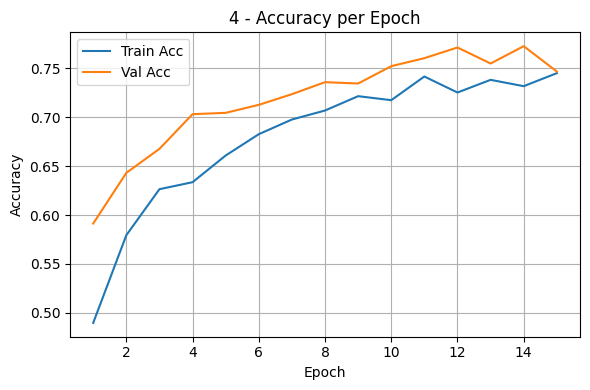

<Figure size 600x600 with 0 Axes>

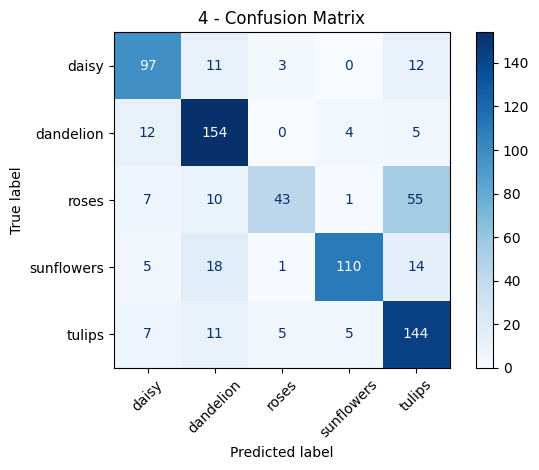


### Running on GPU ###

Starting experiment: 4 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_d

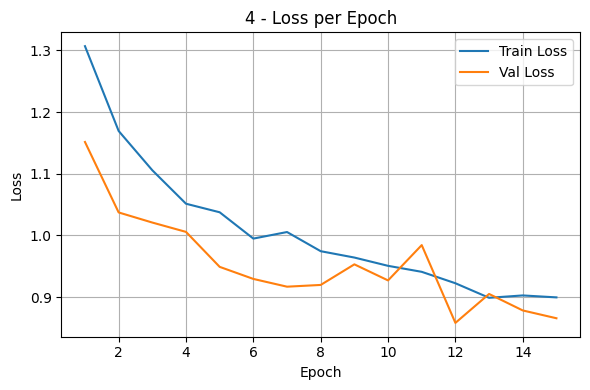

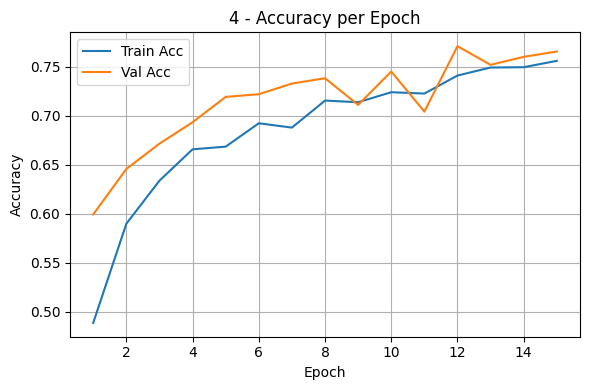

<Figure size 600x600 with 0 Axes>

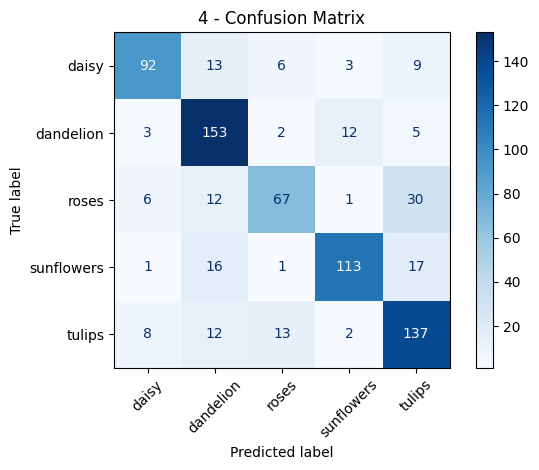


=== CPU vs GPU summary ===
CPU total time: 995.3 s
GPU total time: 216.2 s
Approx. speedup: 4.60x


In [22]:
best_cfg_for_speed = next(
    e for e in experiments
    if e.name == "4"
)

compare_cpu_gpu(best_cfg_for_speed, train_loader, val_loader, class_names, num_classes)
